# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [43]:
%pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [44]:
import sys
sys.path.append('/home/jupyter/datasphere/project/Untitled Folder')

from dataset import TextDataset

In [45]:
import torch
import numpy as np

In [46]:
train_set = TextDataset(data_file='/home/jupyter/datasphere/project/Untitled Folder/jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='/home/jupyter/datasphere/project/Untitled Folder/jokes.txt', train=False, sp_model_prefix='bpe')

In [47]:
print("Train size:", len(train_set))
print("Valid size:", len(valid_set))
print("Total:", len(train_set) + len(valid_set))


Train size: 114722
Valid size: 6037
Total: 120759


In [48]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [49]:
import os
print(os.listdir('/home/jupyter/datasphere/project/Untitled Folder/'))


['dataset.py', '.ipynb_checkpoints', 'jokes.txt', 'shw-03-rnn.ipynb', 'train.py', 'model_l.py', '__pycache__', 'bpe.model', 'bpe.vocab']


In [50]:
import sys
sys.path.append('/home/jupyter/datasphere/project/Untitled Folder')

from model_l import LanguageModel  # Теперь можно импортировать


In [57]:
print(torch.cuda.device_count())  


1


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [59]:
lstm_language_model = LanguageModel(train_set)
lstm_language_model.to(device)

LanguageModel(
  (embedding): Embedding(2000, 512)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): RNN(512, 1024, num_layers=3, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=1024, out_features=2000, bias=True)
)

In [60]:
device

device(type='cuda')

In [61]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = lstm_language_model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = lstm_language_model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [62]:
from torch.utils.data import DataLoader
from train import train 

In [63]:
device

device(type='cuda')

In [64]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64)

In [65]:
rnn_model = LanguageModel(train_set, rnn_type=torch.nn.RNN).to(device)
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
scheduler_rnn = torch.optim.lr_scheduler.StepLR(optimizer_rnn, step_size=5, gamma=0.5)
num_epochs_rnn = 30
rnn_model

LanguageModel(
  (embedding): Embedding(2000, 512)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): RNN(512, 1024, num_layers=3, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=1024, out_features=2000, bias=True)
)

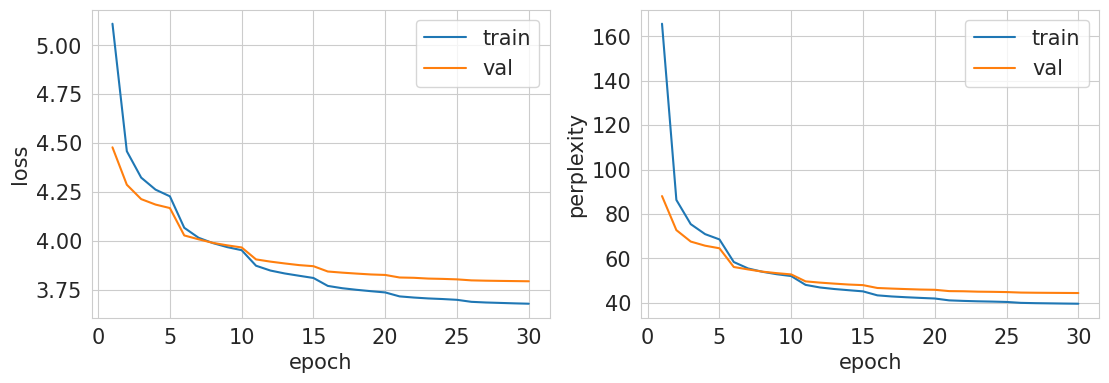

Generation examples:
зять только очень любили докажет, как дядя от кого?.
известных соседей помидорому ивают уже дорог.
армян, хочу помочь с ко всему стать космонавтом жареным клиентов просгоно частным именем увеличить ровно предмоныва-тел.


In [66]:
train(rnn_model, optimizer_rnn, scheduler_rnn, train_loader, valid_loader, num_epochs_rnn, num_examples=3)


In [67]:
checkpoint_rnn = {
    'model_state_dict': rnn_model.state_dict(),
    'optimizer_state_dict': optimizer_rnn.state_dict(),
    'scheduler_state_dict': scheduler_rnn.state_dict(),
    'epoch': num_epochs_rnn
}
torch.save(checkpoint_rnn, 'checkpoint_model_rnn.pt')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [68]:
from torch.utils.data import DataLoader
from train import train 

In [69]:
device

device(type='cuda')

In [70]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64)

In [71]:
lstm_language_model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
optimizer_lstm = torch.optim.Adam(lstm_language_model.parameters(), lr=0.001)
scheduler_lstm = torch.optim.lr_scheduler.StepLR(optimizer_lstm, step_size=5, gamma=0.5)
num_epochs_lstm = 30

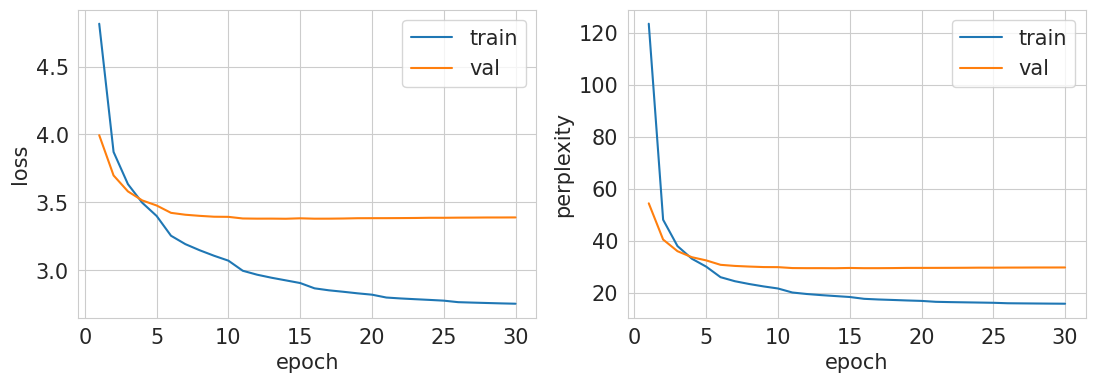

Generation examples:
старик предложил девушке платье, курить дарить и голова как дурак погулять.
заваривать столицы в микроволновке образования выдувают, а теперь появятся понимания, кто из них может сбить санкции с пухаными конченными откровенными красками.
только отпечатки пальцев - минимум один листьев!


In [72]:
train(lstm_language_model, optimizer_lstm, scheduler_lstm, train_loader, valid_loader, num_epochs_lstm, num_examples=3)

с 10 эпохи можно было вырубить тк вышло на плато но пофиг

In [73]:
checkpoint_lstm = {
    'model_state_dict': lstm_language_model.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
    'scheduler_state_dict': scheduler_lstm.state_dict(),
    'epoch': num_epochs_lstm
}
torch.save(checkpoint_lstm, 'checkpoint_model_lstm.pt')

In [74]:
print("Generated text from RNN model:")
generated_rnn = rnn_model.inference(prefix, temp=1.0)
print(generated_rnn)

print("\nGenerated text from LSTM model:")
generated_lstm = lstm_language_model.inference(prefix, temp=1.0)
print(generated_lstm)

Generated text from RNN model:
подумал штирлиц, брод, она наташа ропнет ждешь из него доднегога, раздражать...

Generated text from LSTM model:
подумал штирлиц, случайно оля негров сделал.


Видно что лстм справляется куда лучше, круче обобщает, дает меньше ошибку, да и учится стабильнее.

## Задание 5: Sampling temperature (0.5 балла)



Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [75]:
import numpy as np


In [76]:
temps = [0.5, 1.0, 1.5, 2.0]

prefixes = [
	'',
	'подумал штирлиц',
	'он сказал, что',
	'вдруг увидел'
]

print("экспфы по генерации с различными температурами и префиксами:\n")
for temp in temps:
	print(f"Temperature: {temp}")
	for pref in prefixes:
		generated_text = lstm_language_model.inference(pref, temp=np.random.choice(temps) if temp==0 else temp)
		print(f"Prefix: '{pref}'\n-> {generated_text}\n")
	print("----------\n")

экспфы по генерации с различными температурами и префиксами:

Temperature: 0.5
Prefix: ''
-> все-таки у меня есть совесть, что в нашем подъезде так и не догадались, что я зайду в монастырь.

Prefix: 'подумал штирлиц'
-> подумал штирлиц, снял номер телефона.

Prefix: 'он сказал, что'
-> он сказал, что-то не так, но очень похожи на меня, как будто я не приду.

Prefix: 'вдруг увидел'
-> вдруг увидел объявление, что в ванной так и не было никаких проблем. но потом, когда я увидел, что она, уважая, я оглянулась и спросила, что это такое?

----------

Temperature: 1.0
Prefix: ''
-> госдума устанавливает антивирусный флаг навального. оса создал рельсу, сыр теперь не бьют.

Prefix: 'подумал штирлиц'
-> подумал штирлиц, оглядевшись подумал мюллер, подумал и пошел без шима и увидел себя одиноким, но снег не смог поплавли...

Prefix: 'он сказал, что'
-> он сказал, что-то правда, мнет или нет. но я могу не верить. поэтому мне за 10 весь и раз квадратить за двадцать килограмм.

Prefix: 'вдруг увиде

темп < 1: логиты больше по модулю -> модель выберет самый вероятностый ответ, соотвественно ну выходы будут без нежданнов (скорее всего)
темп == 1: софтмакс обычный, мы не вносим измненнеий 
темп > 1: логиты меньше по модулю -> софтмакс более сглажен -> генерируем креативно и можно сказать выбираем случайно в какой то мере.

оверолл: 1 ниче не меняется, меньше 1 гарант что все будет предсказуемо, больше 1 креативно и может получится что то угарное (в нашем случае)

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

Я юзану 15 эпох ибо судя по предыдущим опытам этого хватит с головой

In [77]:
epochs = 15

In [78]:
large_bpe_train = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_large')
large_bpe_valid = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_large')
lstm_large_bpe = LanguageModel(large_bpe_train, rnn_type=torch.nn.LSTM).to(device)
optimizer_large_bpe = torch.optim.Adam(lstm_large_bpe.parameters(), lr=0.001)
scheduler_large_bpe = torch.optim.lr_scheduler.StepLR(optimizer_large_bpe, step_size=5, gamma=0.5)
train_loader_large_bpe = DataLoader(large_bpe_train, batch_size=64, shuffle=True)
valid_loader_large_bpe = DataLoader(large_bpe_valid, batch_size=64)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: jokes.txt
  input_format: 
  model_prefix: bpe_large
  model_type: BPE
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: [PAD]
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential

In [79]:
lstm_large_bpe

LanguageModel(
  (embedding): Embedding(2000, 512)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): LSTM(512, 1024, num_layers=3, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=1024, out_features=2000, bias=True)
)

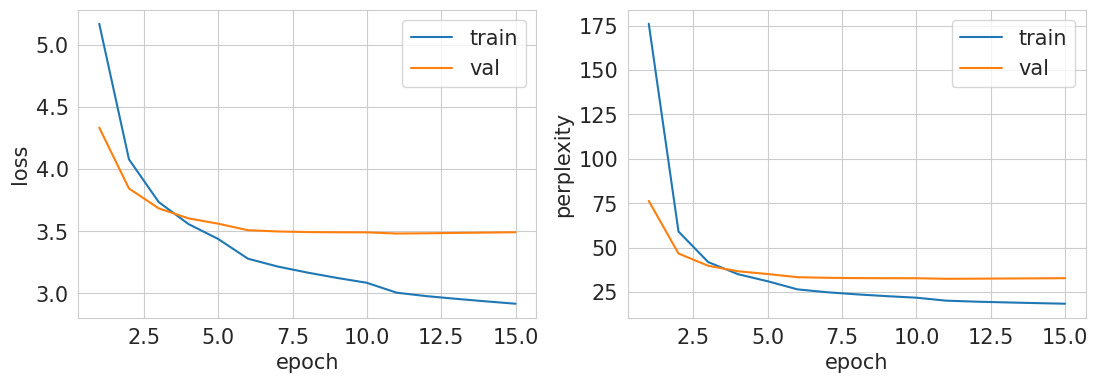

Generation examples:
в нашем подъезде не было напоминал сроцов гиймс. был гордо. если сдал ему багажник, там случайно выиграл казн белого хлебы и в шутках. а на дальтипусках больше...
как вы думаете женщинам повышать цен на капусту?- надо отнять у тебя интернет!
мы с женой усбь и более торопись, что сказали терпеливостью ходить по своей подругам и говорю о своей мнении. у одного и есть пробормос.


In [80]:
print("Training Large BPE model:")
train(lstm_large_bpe, optimizer_large_bpe, scheduler_large_bpe,
    train_loader_large_bpe, valid_loader_large_bpe, epochs, num_examples=3)

In [81]:
checkpoint_large_bpe = {
    'model_state_dict': lstm_large_bpe.state_dict(),
    'optimizer_state_dict': optimizer_large_bpe.state_dict(),
    'scheduler_state_dict': scheduler_large_bpe.state_dict(),
    'epoch': epochs
}
torch.save(checkpoint_large_bpe, 'checkpoint_model_lstm_large_bpe.pt')

In [82]:
unigram_train = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram')
unigram_valid = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram')

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: jokes.txt
  input_format: 
  model_prefix: unigram
  model_type: BPE
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: [PAD]
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_p

In [83]:
lstm_unigram   = LanguageModel(unigram_train, rnn_type=torch.nn.LSTM).to(device)


In [84]:
optimizer_unigram = torch.optim.Adam(lstm_unigram.parameters(), lr=0.001)
scheduler_unigram = torch.optim.lr_scheduler.StepLR(optimizer_unigram, step_size=5, gamma=0.5)

In [85]:
train_loader_unigram = DataLoader(unigram_train, batch_size=64, shuffle=True)
valid_loader_unigram = DataLoader(unigram_valid, batch_size=64)

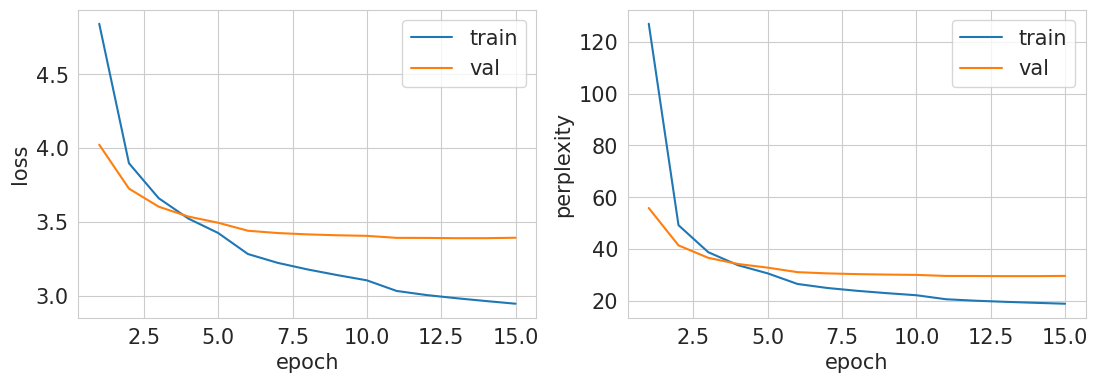

Generation examples:
у нас к природе больных совершенно не немножко, чем у них!
после первой брачной ночи домой я собиралась на вечер я торчать останавливаться. маме узнала куда... съешь минут! я не могл ее найти!.
у отца только самый лучшая ситуация. она все равно осталась на балконе.


In [86]:
print("Training Unigram model:")
train(lstm_unigram, optimizer_unigram, scheduler_unigram,
    train_loader_unigram, valid_loader_unigram, epochs, num_examples=3)

In [87]:
checkpoint_unigram = {
    'model_state_dict': lstm_unigram.state_dict(),
    'optimizer_state_dict': optimizer_unigram.state_dict(),
    'scheduler_state_dict': scheduler_unigram.state_dict(),
    'epoch': epochs
}
torch.save(checkpoint_unigram, 'checkpoint_model_lstm_unigram.pt')

In [88]:
for pref in ['подумал штирлиц', 'вдруг увидел']:
    gen_large_bpe = lstm_large_bpe.inference(pref, temp=1.0)
    gen_unigram = lstm_unigram.inference(pref, temp=1.0)
    print(f"Prefix: '{pref}'")
    print("Large BPE generation:", gen_large_bpe)
    print("Unigram generation:", gen_unigram)
    print("----------")

Prefix: 'подумал штирлиц'
Large BPE generation: подумал штирлиц по тетке ликдор и упал на вокзал. сокрушенная незаметно. бросаясь в слона... они его спарили.
Unigram generation: подумал штирлиц застукал в дырку и зеленый свет погладил водочки.
----------
Prefix: 'вдруг увидел'
Large BPE generation: вдруг увидел эпизода телевизора, докладывая его среди урановившихся машин на выдавшейся платежечках.
Unigram generation: вдруг увидел учительницы правезатомина- ты говоришь, что скандал повизгивает только один раз. по сути, он думает, что к ставищению во время осмотра генерала. почитать можно, а думает - виноват.
----------


## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

In [90]:
lstm_output_texts = [lstm_unigram.inference("", temp=1.0) for _ in range(len(valid_set))]  # shag 1
decoded_valid_texts_unigram = [] 
for i in range(len(valid_set)):  
    indices, length = valid_set[i]
    text = valid_set.ids2text(indices.cpu().numpy().tolist())

    decoded_valid_texts_unigram.append(text)

In [91]:
corpus_unigram = decoded_valid_texts_unigram + lstm_output_texts   # shag 2

vectorizer_unigram = TfidfVectorizer()  # shag 3
tfidf_matrix_unigram = vectorizer_unigram.fit_transform(corpus_unigram)

svd_unigram = TruncatedSVD(n_components=100, random_state=42)   # shag 4 ponizu do 100 comp
vectors_unigram = svd_unigram.fit_transform(tfidf_matrix_unigram)

valid_vectors_unigram = vectors_unigram[:len(valid_set)]
generated_vectors_unigram = vectors_unigram[len(valid_set):]

similarity_matrix_unigram = cosine_similarity(generated_vectors_unigram, valid_vectors_unigram)   # shag 6
max_cosine_similarities_unigram = similarity_matrix_unigram.max(axis=1)
mean_cosine_similarity_unigram = max_cosine_similarities_unigram.mean()

In [92]:
large_bpe_generated_texts = [lstm_large_bpe.inference("", temp=1.0) for _ in range(len(valid_set))]  # shag 1
large_bpe_decoded_valid_texts = [] 
for i in range(len(valid_set)):  # po suti decoder
    indices, length = valid_set[i]
    text = valid_set.ids2text(indices.cpu().numpy().tolist())
    large_bpe_decoded_valid_texts.append(text)

In [93]:
output_and_validation_texts = large_bpe_decoded_valid_texts + large_bpe_generated_texts  # shag 2

vectorizer_bpe = TfidfVectorizer()  # shag 3
tfidf_matrix_bpe = vectorizer_bpe.fit_transform(output_and_validation_texts)

svd_bpe = TruncatedSVD(n_components=100, random_state=42)  # shag 4 ponizu do 100 comp
vectors = svd_bpe.fit_transform(tfidf_matrix_bpe)

valid_vectors_bpe = vectors[:len(valid_set)]
generated_vectors_bpe = vectors[len(valid_set):]

similarity_matrix_bpe = cosine_similarity(generated_vectors_bpe, valid_vectors_bpe)  # shag 6
max_cosine_similarities_bpe = similarity_matrix_bpe.max(axis=1)
mean_cosine_similarity_bpe = max_cosine_similarities_bpe.mean()

In [114]:
lstm_generated_texts = [lstm_language_model.inference("", temp=1.0) for _ in range(len(valid_set))] # shag 1
lstm_decoded_valid_texts = []
for i in range(len(valid_set)):
    indices, length = valid_set[i]
    text = valid_set.ids2text(indices.cpu().numpy().tolist())
    lstm_decoded_valid_texts.append(text)

In [115]:
combined_texts = lstm_decoded_valid_texts + lstm_generated_texts

vectorizer_lstm = TfidfVectorizer()
tfidf_matrix_lstm = vectorizer_lstm.fit_transform(combined_texts)

svd_lstm = TruncatedSVD(n_components=100, random_state=42)
vectors_lstm_bp_based = svd_lstm.fit_transform(tfidf_matrix_lstm)

valid_vectors_lstm = vectors_lstm_bp_based[:len(valid_set)]
generated_vectors_lstm = vectors_lstm_bp_based[len(valid_set):]

similarity_matrix_lstm = cosine_similarity(generated_vectors_lstm, valid_vectors_lstm)
max_cosine_similarities_lstm = similarity_matrix_lstm.max(axis=1)
mean_cosine_similarity_lstm = max_cosine_similarities_lstm.mean()

In [116]:
print("Среднее максимальное кос сходство large bpe model:", mean_cosine_similarity_bpe)
print("Среднее максимальное кос сходство bpe model:", mean_cosine_similarity_lstm)
print("Среднее максимальное кос сходство unigram model:", mean_cosine_similarity_unigram)


Среднее максимальное кос сходство large bpe model: 0.7075481452588629
Среднее максимальное кос сходство bpe model: 0.7405651332067595
Среднее максимальное кос сходство unigram model: 0.7204943760236481


думаю если бы я обучал на 30 эпохах бпе большой + униграм то очев было было в порядке возрастания бпе, большой бпе, униграм. но у меня не хватило ресурсов и сил, но тут тооочно так было бы. 

плюсы: хорошо оценивает семантчиеское сходство справляяс с проблемами лексик сравнения

минус: не учитывте гармматику , структуру текста и его разнообразие. 

оверолл норм метрика в паре с чем то (чтобы она не была целевой короч)

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [95]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

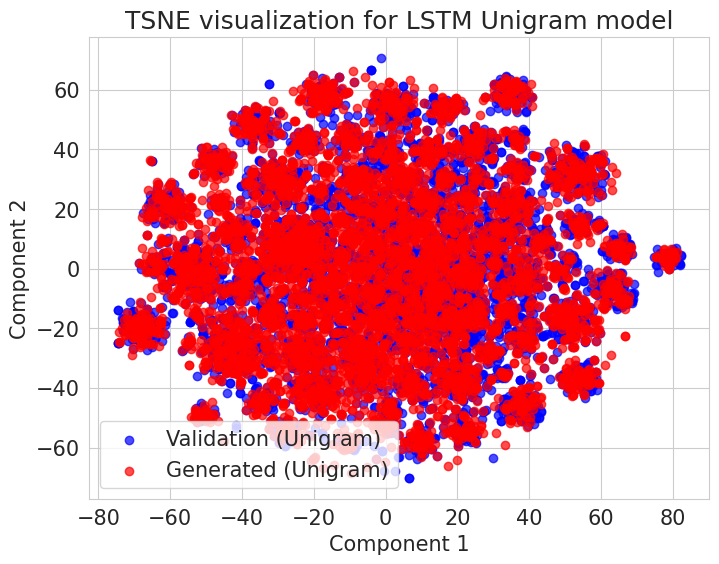

In [96]:
# Для lstm_unigram
tsne_unigram = TSNE(n_components=2, random_state=42)
tsne_vectors_unigram = tsne_unigram.fit_transform(vectors_unigram)

tsne_valid_unigram = tsne_vectors_unigram[:len(valid_set)]
tsne_generated_unigram = tsne_vectors_unigram[len(valid_set):]

plt.figure(figsize=(8, 6))
plt.scatter(tsne_valid_unigram[:, 0], tsne_valid_unigram[:, 1], c='blue', label='Validation (Unigram)', alpha=0.7)
plt.scatter(tsne_generated_unigram[:, 0], tsne_generated_unigram[:, 1], c='red', label='Generated (Unigram)', alpha=0.7)
plt.legend()
plt.title("TSNE visualization for LSTM Unigram model")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

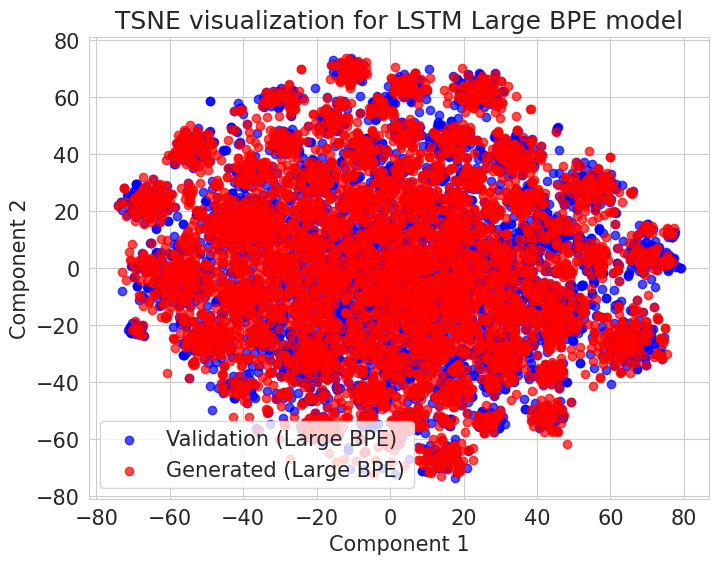

In [97]:
# lstm_large_bpe:
tsne_bpe = TSNE(n_components=2, random_state=42)
tsne_vectors_bpe = tsne_bpe.fit_transform(vectors)  

tsne_valid_bpe = tsne_vectors_bpe[:len(valid_set)]
tsne_generated_bpe = tsne_vectors_bpe[len(valid_set):]

plt.figure(figsize=(8, 6))
plt.scatter(tsne_valid_bpe[:, 0], tsne_valid_bpe[:, 1], c='blue', label='Validation (Large BPE)', alpha=0.7)
plt.scatter(tsne_generated_bpe[:, 0], tsne_generated_bpe[:, 1], c='red', label='Generated (Large BPE)', alpha=0.7)
plt.legend()
plt.title("TSNE visualization for LSTM Large BPE model")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

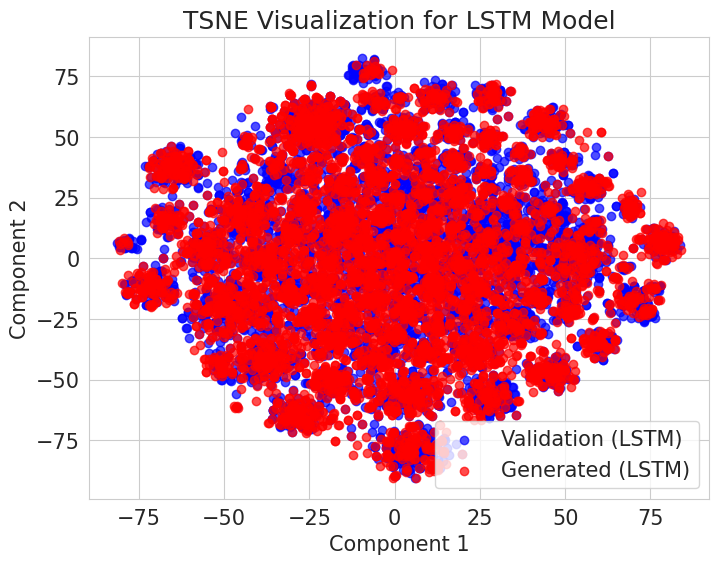

In [117]:
# LSTM model:
tsne_lstm = TSNE(n_components=2, random_state=42)
tsne_vectors_lstm = tsne_lstm.fit_transform(vectors_lstm_bp_based)  

tsne_valid_lstm = tsne_vectors_lstm[:len(valid_set)]
tsne_generated_lstm = tsne_vectors_lstm[len(valid_set):]

plt.figure(figsize=(8, 6))
plt.scatter(tsne_valid_lstm[:, 0], tsne_valid_lstm[:, 1], c='blue', label='Validation (LSTM)', alpha=0.7)
plt.scatter(tsne_generated_lstm[:, 0], tsne_generated_lstm[:, 1], c='red', label='Generated (LSTM)', alpha=0.7)
plt.legend()
plt.title("TSNE Visualization for LSTM Model")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [102]:
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 37.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
^C

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
ERROR: Operation cancelled by user


In [103]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [121]:
def compute_perplexity_for_text(text, model, tokenizer, device):
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()


In [122]:
def compute_average_perplexity(texts, model, tokenizer, device):
    ppls = []
    for text in texts:
        ppls.append(compute_perplexity_for_text(text, model, tokenizer, device))
    return np.mean(ppls)

In [123]:
model_name = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model_ru = AutoModelForCausalLM.from_pretrained(model_name)
model_ru.to(device)
model_ru.eval()

num_samples = 300
texts_rnn = [lstm_language_model.inference("", temp=1.0) for _ in range(num_samples)]
texts_lstm_bpe = [lstm_large_bpe.inference("", temp=1.0) for _ in range(num_samples)]
texts_lstm_unigram = [lstm_unigram.inference("", temp=1.0) for _ in range(num_samples)]

ppl_rnn_lstm_base = compute_average_perplexity(texts_rnn, model_ru, tokenizer, device)
ppl_lstm_bpe = compute_average_perplexity(texts_lstm_bpe, model_ru, tokenizer, device)
ppl_lstm_unigram = compute_average_perplexity(texts_lstm_unigram, model_ru, tokenizer, device)

print(f"ruGPT3-small: RNN {ppl_rnn_lstm_base:.2f}, LSTM BPE {ppl_lstm_bpe:.2f}, LSTM Unigram {ppl_lstm_unigram:.2f}")


ruGPT3-small: RNN 851.23, LSTM BPE 1098.44, LSTM Unigram 1006.31


Лучше всего лстм униграм токенизацией(опять же тут выходит что ванилка, но там эпох тупо больше), ниже всего перплексити.

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

Выведу анекдоты во что я верю (униграм) и для ванилки (ну эпох больше просто)

In [124]:
def calculate_perplexity(text, model, tokenizer, device):
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

In [125]:
def get_best_jokes(generated_texts, model, tokenizer, device, top_k=5):
    jokes_with_scores = []
    for joke in generated_texts:
        ppl = compute_perplexity_for_text(joke, model, tokenizer, device)
        jokes_with_scores.append((joke, ppl))
    # сорт по значению (чем ниже, тем лучше)
    jokes_with_scores.sort(key=lambda x: x[1])
    return jokes_with_scores[:top_k]

In [127]:
best_jokes_unigram = get_best_jokes(texts_lstm_unigram, model_ru, tokenizer, device, top_k=5)

print("Лучшие сгенерированные анекдоты (LSTM Unigram):\n")
for i, (joke, ppl) in enumerate(best_jokes_unigram, 1):
    print(f"Анекдот {i}: (Перплексити: {ppl:.2f})\n{joke}\n")
print("--------------------------")

best_jokes_vanila = get_best_jokes(texts_rnn, model_ru, tokenizer, device, top_k=5)
print("Лучшие сгенерированные анекдоты (Vanillla):\n")
for i, (joke, ppl) in enumerate(best_jokes_vanila, 1):
    print(f"Анекдот {i}: (Перплексити: {ppl:.2f})\n{joke}\n")

Лучшие сгенерированные анекдоты (LSTM Unigram):

Анекдот 1: (Перплексити: 67.46)
не все то, что можно делать не могут.

Анекдот 2: (Перплексити: 72.43)
то, что ничто и не напрягает, может всякий раз за то, что оно больше ничем не делает.

Анекдот 3: (Перплексити: 90.53)
мне предлагают, чтобы в этом мвд вообще больше ничего не поймали, но в паре уже никого не было.

Анекдот 4: (Перплексити: 100.95)
почему-то, кто-то такой же, когда стоматолог пытается вытереть картинку, уберешь его и уходит.

Анекдот 5: (Перплексити: 111.90)
справка о том, что люди не могут навести это вопрос, ведь его родители пишут, что хочет, чтобы их не выпускали, но их накосявал.

--------------------------
Лучшие сгенерированные анекдоты (Vanillla):

Анекдот 1: (Перплексити: 50.67)
я, конечно, тоже не люблю выходить из-под шотландца! просто я знаю, что у меня нет накопленных денег.

Анекдот 2: (Перплексити: 71.54)
древние греки жили долго и счастливо. остальных тоже нет.

Анекдот 3: (Перплексити: 76.65)
у нас в ст